In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from ephys_queries import db_setup_core, select_spike_times, select_discrete_data
from dotenv import load_dotenv

In [2]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [3]:
df = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: 
         (x["group_name"].isin((
            "acute_citalopram", 
            "acute_saline", 
            "shock", 
            "sham", 
            "acute_cit", 
            "acute_sal"
                ))
        ) & (
         x["cluster"] != "no_baseline")]
)

In [4]:
df_response = (pd.read_csv(data_dir / "baseshock_response.csv"))

In [5]:
group_names = ["acute_citalopram", "acute_saline", "shock", 
               "sham", "acute_cit", "acute_sal"]
block_name = "base_shock"
fs = 30000

load_dotenv()
engine, metadata = db_setup_core()
session= "hamilton_36"

In [6]:
(
    df[["neuron_id", "session_name","cluster"]]
    .groupby(['session_name', "cluster"])
    .apply(len)
    .reset_index()
    .loc[lambda x: x["session_name"]==session]
)

,session_name,cluster,0
53,hamilton_36,fast_firing,4
54,hamilton_36,slow_irregular,13
55,hamilton_36,slow_regular,7


In [7]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
        session_names=[session]
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)
df_events = (
    select_discrete_data(
        engine, metadata, 
        block_name=block_name,
        group_names=group_names,
    )
    .loc[lambda x: x["session_name"]==session]
    .assign(
        event_s= lambda x: x["timepoint_sample"].divide(fs)
    )
)

In [8]:
df_events.head()

,signal_name,session_name,timepoint_sample,group_name,event_s
1574,eshock,hamilton_36,54371645,acute_cit,1812.388167
1575,eshock,hamilton_36,54431633,acute_cit,1814.387767
1576,eshock,hamilton_36,54491620,acute_cit,1816.387333
1577,eshock,hamilton_36,54551608,acute_cit,1818.386933
1578,eshock,hamilton_36,54611595,acute_cit,1820.386500


In [ ]:
"hamilton_36"

In [9]:
df_spikes = df_spikes.merge(df_response[["label", "neuron_id"]])

In [10]:
from spiketimes.df.conversion import df_to_list


_, inhibs = df_to_list(df_spikes[df_spikes["label"] == "inhibited"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, stims = df_to_list(df_spikes[df_spikes["label"] == "stimulated"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

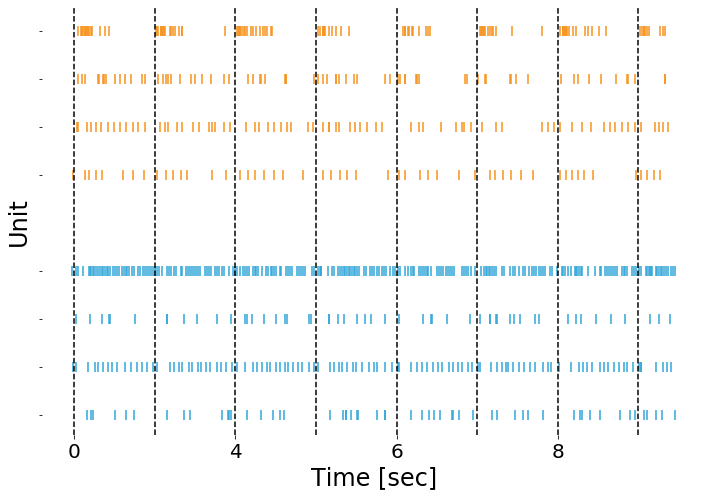

In [11]:
from spiketimes.plots import grouped_raster, add_event_vlines
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 7))

t_start = 1900.3
t_stop = t_start + 15

events = (
    df_events[
        (df_events["event_s"] >= t_start) & (df_events["event_s"] <= t_stop)]
    ["event_s"].values
)

ax = grouped_raster([inhibs[2::2], stims[::2]],
                    ["#31A6D9", "#F6931D"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=1,
               plot_kwargs={"s":90},
                   ax=ax)

ax.set_yticks(ticks=[0, 1, 2, 3, 5,6 , 7, 8])
ax.set_yticklabels([])

ax.set_xticks(ticks=events[::2])
ax.set_xticklabels([0, 4, 6, 8], fontsize=20)


ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

add_event_vlines(ax, events)

plt.tight_layout()
plt.savefig(fig_dir / "psth_raster.png", transparent=True, dpi=300)

In [49]:
events[::2]

array([1900.3709    , 1904.37016667, 1908.3694    , 1912.36866667])